In [234]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

## Data Preparation for ARIMA models

In crafting the dataset for ARIMA exploration, I refined the variables to focus solely on the date and the target prediction variable, streamlining the analytical focus. The dataset was then grouped by 'Date', with the date serving as a distinctive index. Despite the initial weekly format of the data, ARIMA posed challenges related to datetime intricacies and convergence warnings. To mitigate these concerns, I opted for a weekly resampling approach, successfully rectifying errors linked to datetime disparities. Additionally, I introduced scaling to the dataset for uniformity in model comparisons, even though ARIMA traditionally doesn't necessitate scaling. These intentional steps in dataset preparation laid a robust groundwork for ARIMA modeling, ensuring reliability in subsequent analyses and interpretations.

In [251]:
import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

pred_var = 'Additional_Doses_Vax_Pct'

df = pd.read_csv('df_post_eda.csv')

# group data by Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

#subset data to be only dates and predicting variable values
data = pd.DataFrame(df)

# resambpling to weekly datetime to prevent convergence warnings
data_w = data.resample('W').sum()

#scaling data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(min_max_scaler.fit_transform(data_w), columns=data.columns, index=data_w.index)

## Investigating Stationarity

In evaluating the stationarity of the time series data, I made several key observations. Firstly, I identified a noticeable constant increasing trend in the prediction variable, suggesting non-stationarity. This is consistent with the theoretical definition of stationarity, where statistical properties such as the mean should remain constant over time—a condition inherently violated by a cumulative percentage prediction variable. To formally investigate stationarity, I opted for the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, seeking to test the null hypothesis that the data is stationary around a deterministic trend. The outcome of the KPSS test led to the rejection of the null hypothesis, reinforcing the non-stationary nature of the data. Subsequently, I delved into a detailed examination of the autocorrelation function (ACF) graph. The gradual decline in the trend observed in the ACF graph further supports the non-stationary characteristics of the data, as a stationary time series would typically exhibit a more rapid decay in autocorrelation. This thorough analysis, combining statistical testing and graphical exploration, provides a robust confirmation of the non-stationary nature of the prediction variable.

In [236]:
from statsmodels.tsa.stattools import kpss

result = kpss(data)
# Print the results
print(f'KPSS Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Interpret the results
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis).')
else:
    print('The time series is stationary (fail to reject the null hypothesis).')


KPSS Statistic: 1.0632874725225505
P-value: 0.01
The time series is non-stationary (reject the null hypothesis).


In addressing the prerequisite of stationarity for ARIMA modeling, I tried different orders of differentiation to transform the data appropriately. This process holds significance as ARIMA models assume stationary data for accurate forecasting. Upon inspecting the plots of the differentiated data, particularly after two orders of differencing, data appeared to be stationary. The resulting plot over time showcased a tendency of outliers, yet, on the whole, had a mean of 0. This observation aligns with the concept of stationarity, where the mean remains constant over time. To reinforce this, I scrutinized the autocorrelation function (ACF) plots for the different differentiations. The ACF plot for two orders of differencing exhibited a rapid drop-off, indicating a lack of significant autocorrelation beyond a few lags. This fast decay is indicative of stationary data, supporting the effectiveness of the double differentiation in achieving stationarity. In summary, the differentiation process, backed by visual inspection and ACF analysis, was pivotal in rendering the data stationary and, consequently, suitable for ARIMA modeling.

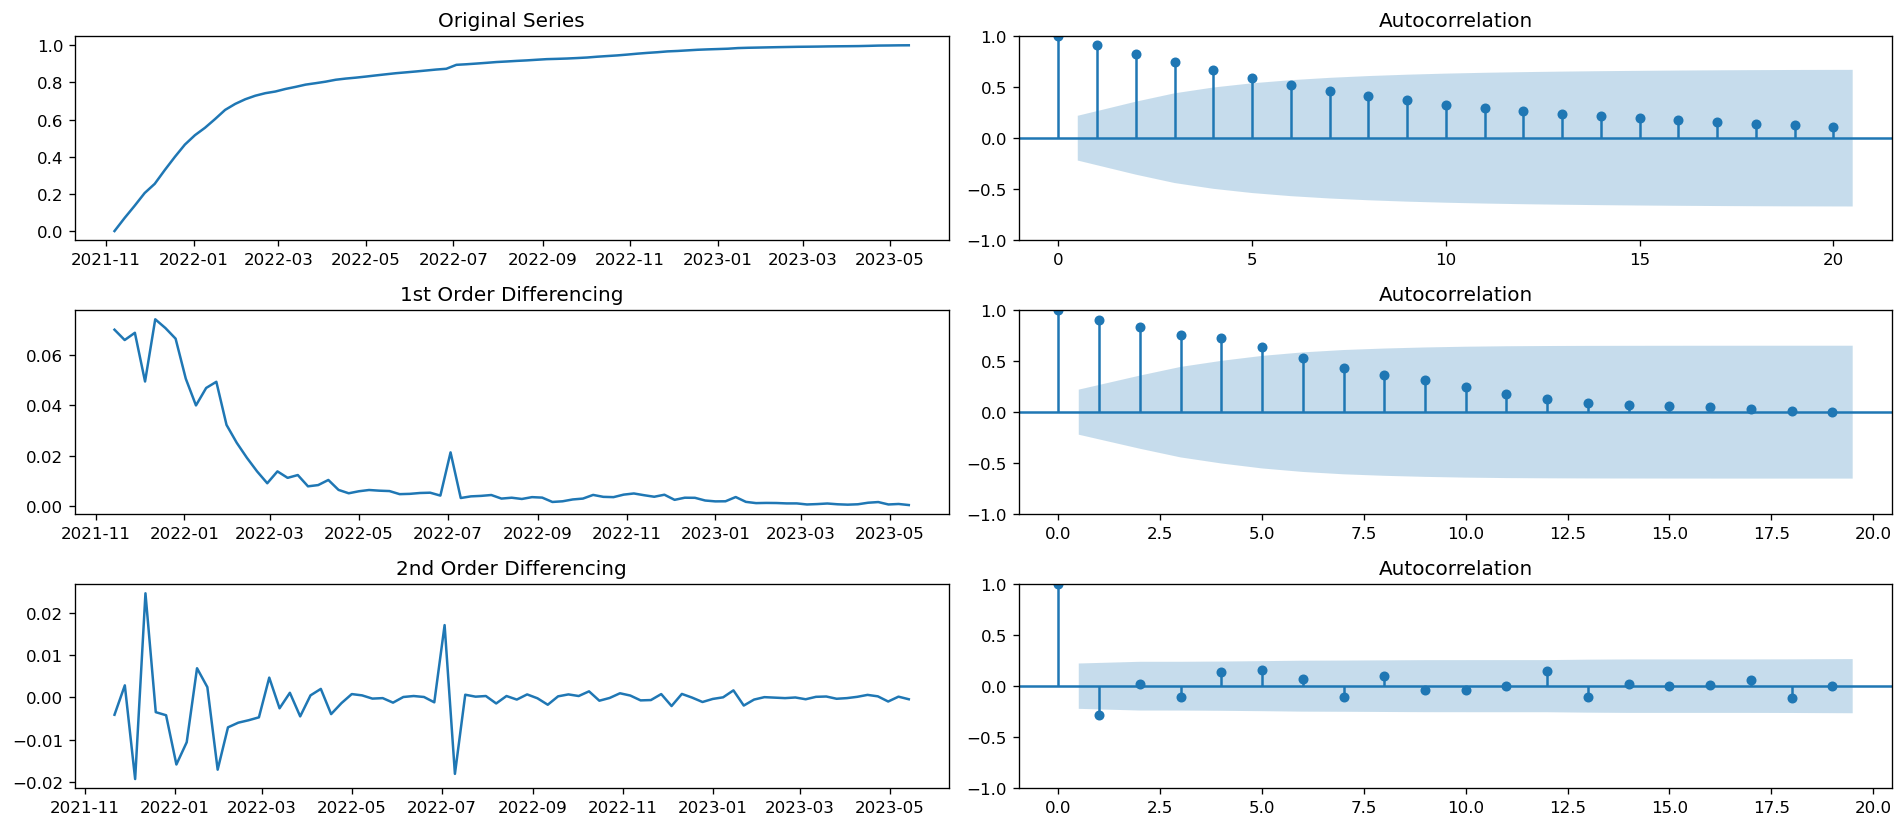

In [237]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(16, 7))

axes[0, 0].plot(data.index, data.values)
axes[0, 0].set_title('Original Series')
plot_acf(data, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.index, data.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.index, data.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

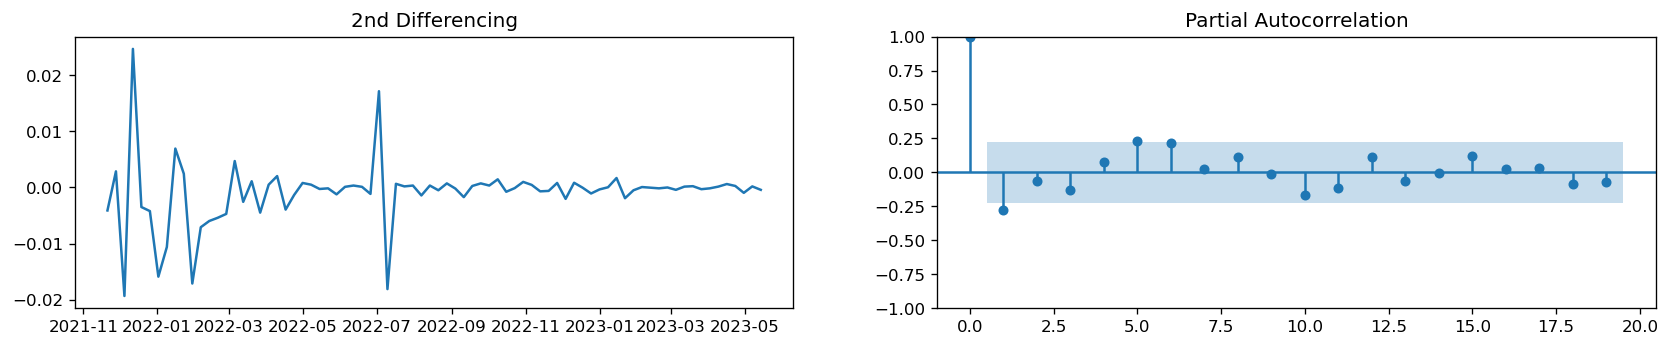

In [238]:
plt.rcParams.update({'figure.figsize':(17,3)})

fig, axes = plt.subplots(1, 2)
axes[0].plot(data.index, data.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.diff().diff().dropna(), ax=axes[1])

plt.show()

In constructing the ARIMA model, I focused on three key parameters: p, d, and q, governing the autoregressive (AR), differencing (I), and moving average (MA) components, respectively.
My parameter choices were guided by a thorough analysis of the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. Initially, I observed that the data achieved stationarity after undergoing two orders of differencing (d=2), as revealed by the ACF plot. Additionally, none of the lags exceeded the significance limit, leading me to choose an initial value of q=0.
Further insights from the PACF plot indicated that, post two orders of differencing, only the first lag slightly exceeded the significance limit. Consequently, for the initial ARIMA model, I opted for p=1.
In essence, my parameter selection process involved a meticulous examination of ACF and PACF plots to ensure the model aptly captured the stationary characteristics of the differentiated data.

## Seasonality Decomposition

In my ARIMA modeling approach, I opted not to perform seasonal decomposition. ARIMA models inherently address non-seasonal time series data through differencing to attain stationarity. My data exhibited a constant increasing trend, and after differentiating twice, it demonstrated characteristics of stationarity. Importantly, my time series did not reveal any prominent seasonal patterns through visual inspection, and the Autocorrelation Function (ACF) plot did not indicate significant lags associated with seasonality. Given the absence of a strong seasonal component, incorporating seasonal decomposition would have introduced unnecessary complexity to the model without a clear benefit. Thus, I decided to focus on leveraging ARIMA's capability to capture non-seasonal dynamics and achieve an optimal model fit.

Cumulative time series data typically does not exhibit seasonal trends. Seasonality in time series data refers to patterns that repeat at regular intervals, such as daily, weekly, or yearly cycles. Cumulative data, which represents the accumulation or running total over time, tends to show a general increasing or decreasing trend rather than repeating patterns at specific intervals.

In [255]:
data_diff = data.diff().dropna()

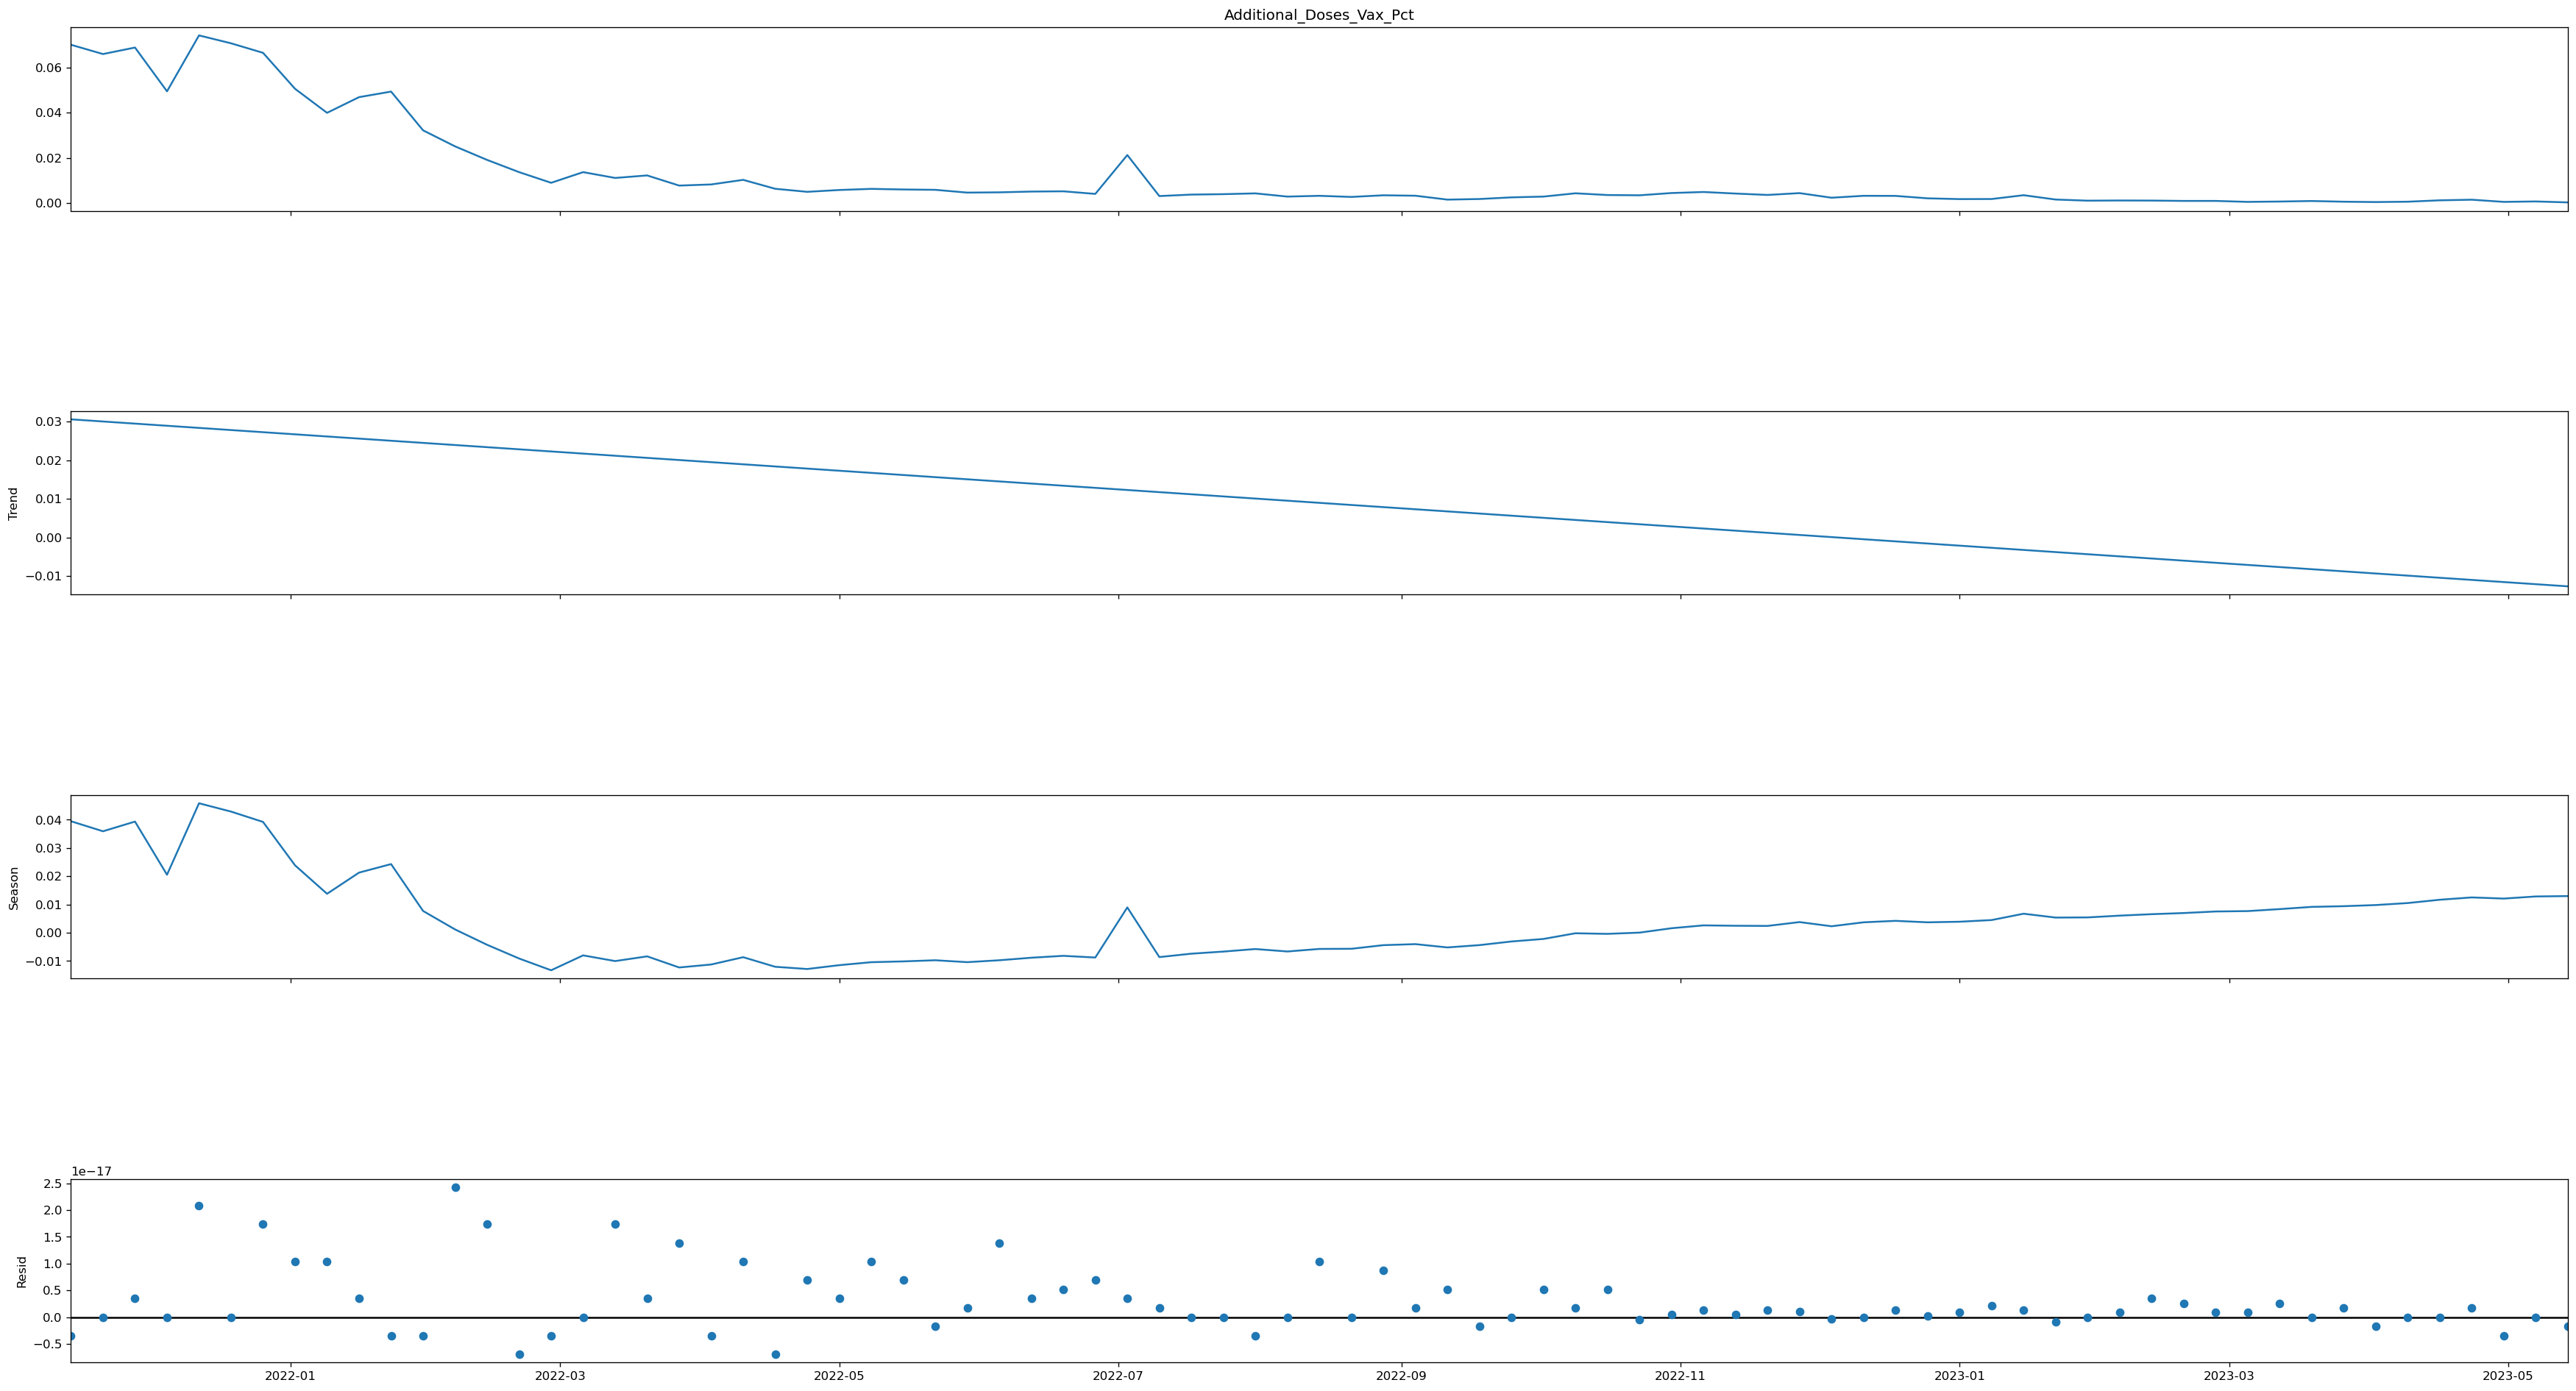

In [267]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

period = 11

# Perform STL decomposition
stl = STL(data_diff[pred_var], seasonal=period)
result = stl.fit()

# Plot the components

fig = result.plot()
fig.set_figwidth(30)  # Set the width of the figure
fig.set_figheight(20)
plt.show()


##  ARIMA Model

In formulating the model for my project, I opted for an 80/20 train and test split. A deliberate choice was made to forgo a random split, ensuring the preservation of chronological order based on the temporal variable, Date. This strategic sorting enables the training set to encompass historical observations, preventing any data leakage problems.
For assessing the model's performance, I chose the Root Mean Squared Error (RMSE) as the evaluation metric. RMSE is well-suited for time series prediction models as it accounts for the squared differences between predicted and actual values, emphasizing the significance of prediction accuracy. Importantly, RMSE penalizes larger errors more severely, aligning with the goal of minimizing prediction discrepancies. This metric's sensitivity to both magnitude and direction of errors makes it a valuable tool for gauging the overall accuracy of the model across the entire time series, providing a comprehensive measure of predictive performance.

In [239]:
# Split data into test and train

split_date = int(len(data) * 0.8)
data = data.sort_index(ascending=True)

# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]


For my initial ARIMA model I have used the paramters specified above..

In [240]:
# 1,1,2 ARIMA Model
base_model = ARIMA(train_data, order=(1,2,0)).fit()
print(base_model.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   64
Model:                       ARIMA(1, 2, 0)   Log Likelihood                 226.255
Date:                      Thu, 23 Nov 2023   AIC                           -448.510
Time:                              15:32:09   BIC                           -444.256
Sample:                          11-07-2021   HQIC                          -446.840
                               - 01-22-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2511      0.073     -3.446      0.001      -0.394      -0.108
sigma2      3.955e-05   4.53e-06      8.727      0.000    3.07e-05    4.84e-05
Ljun

- From the model summary I could tell that the AR1 term was significant( P>|z|) and had a non zero coefficient.

Train RMSE: 0.010722322795040188
Test RMSE: 0.010499051802472514


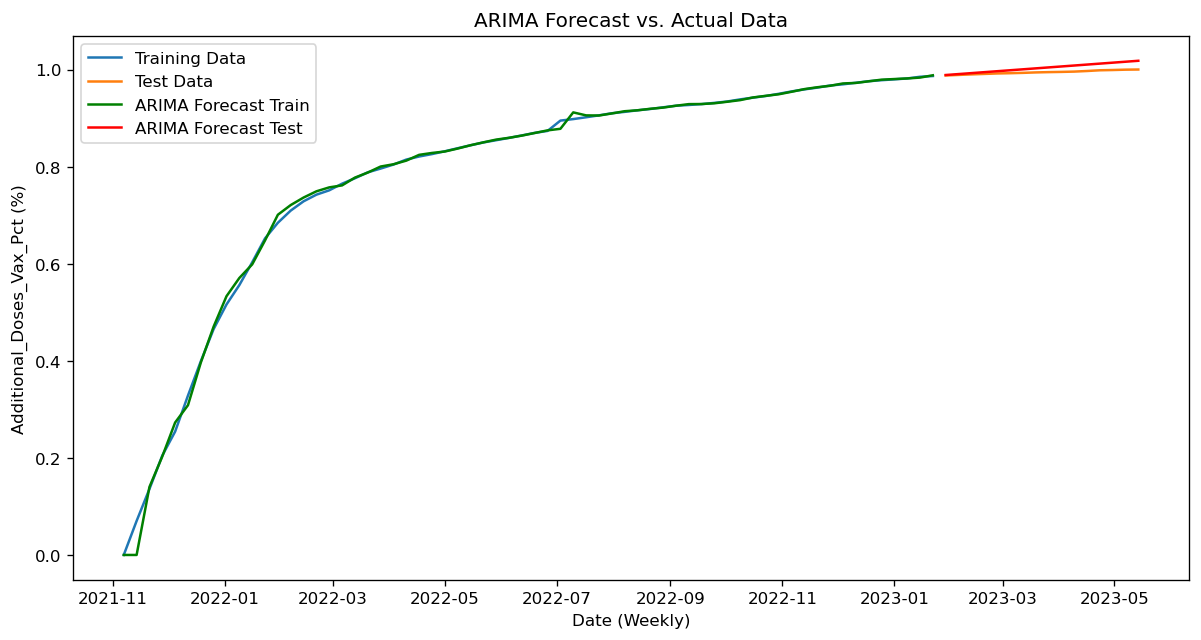

In [241]:
# Forecast future values using the ARIMA model
n_forecast = len(test_data)
forecast = base_model.forecast(steps=n_forecast)
forcast_train = base_model.predict(start = train_data.index[0], end = train_data.index[-1], type = 'levels')


# Evaluate the model's performance
train_rmse = sqrt(mean_squared_error(train_data, forcast_train))
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {rmse}")


# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(train_data.index, forcast_train, label='ARIMA Forecast Train', color='green' )
plt.plot(test_data.index, forecast, label='ARIMA Forecast Test', color='red')
#plt.plot(data.index, forecast_whole, label='ARIMA', color='pink')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.xlabel('Date (Weekly)')
plt.ylabel('Additional_Doses_Vax_Pct (%)')
plt.show()

In [242]:
# residuals

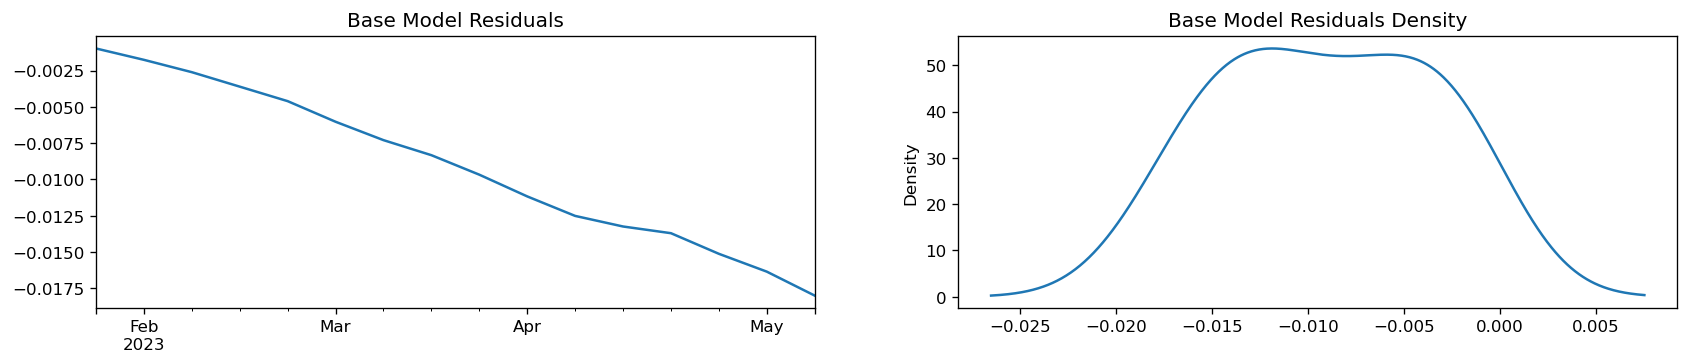

In [243]:
# Plot residual errors
forecast_test_df = forecast.to_frame()
forecast_test_df['residuals']=test_data.values - forecast_test_df.values
residuals = forecast_test_df.residuals
fig, ax = plt.subplots(1,2)
residuals.plot(title="Base Model Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Base Model Residuals Density', ax=ax[1])
plt.show()

Text(0.5, 1.0, 'Base Model ACF of Correlated Residuals')

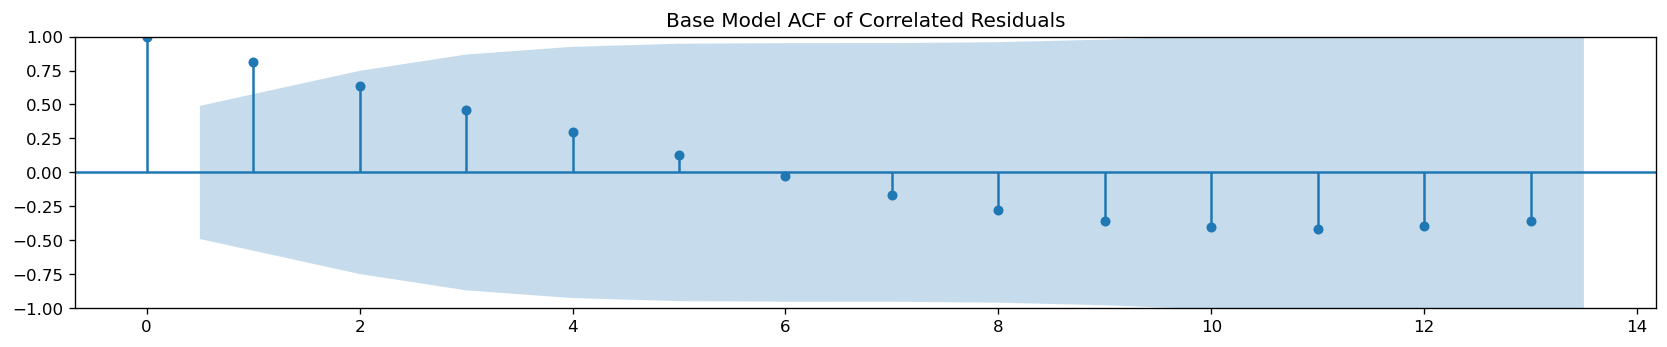

In [244]:
# Original Series
plt.figsize=(10, 8)
acf_original = plot_acf(residuals)
plt.title("Base Model ACF of Correlated Residuals")

Upon meticulous analysis of various plots, several crucial insights surfaced. The negative slope observed in the residuals over time suggests a systematic trend that the ARIMA model might not have adequately captured, implying a potential need for adjustments in differencing or trend components. Additionally, the density plot showcasing a non-normal distribution of residuals raises concerns about deviations from the ideal Gaussian distribution. Ideally, residuals should resemble white noise, and non-normality indicates the presence of unexplored patterns or information. Moreover, the clear pattern discernible in the autocorrelation function (ACF) plot of residuals points to lingering correlations at specific lags, highlighting shortcomings in capturing temporal dependencies. Despite seemingly satisfactory RMSE performance and fit of the above graph, a more detailed examination of residuals revealed substantial patterns that the base ARIMA model failed to address. To enhance the model's performance, I turned to Grid Search for hyperparameter tuning, as well as employed rolling one-step forecast technique for its heightened adaptability in capturing underlying data patterns.

In [245]:
# Grid Search

In [ ]:
#https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [181]:
# grid search ARIMA parameters for time series
# backtesting time series
# evaluate an ARIMA model for a given order (p,d,q)
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.8)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.8f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.8f' % (best_cfg, best_score))

    
# evaluate parameters
p_values = [0, 1,2,3,4]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.18981574
ARIMA(0, 0, 1) RMSE=0.09810078
ARIMA(0, 0, 2) RMSE=0.05439652
ARIMA(0, 1, 0) RMSE=0.00089389
ARIMA(0, 1, 1) RMSE=0.00067407
ARIMA(0, 1, 2) RMSE=0.00068945
ARIMA(0, 2, 0) RMSE=0.00037564
ARIMA(0, 2, 1) RMSE=0.00040793
ARIMA(0, 2, 2) RMSE=0.00042322
ARIMA(1, 0, 0) RMSE=0.00151377
ARIMA(1, 0, 1) RMSE=0.00508656
ARIMA(1, 0, 2) RMSE=0.00397080
ARIMA(1, 1, 0) RMSE=0.00035116
ARIMA(1, 1, 1) RMSE=0.00040781
ARIMA(1, 1, 2) RMSE=0.00041440
ARIMA(1, 2, 0) RMSE=0.00042663
ARIMA(1, 2, 1) RMSE=0.00041342
ARIMA(1, 2, 2) RMSE=0.00108889
ARIMA(2, 0, 0) RMSE=0.00204460
ARIMA(2, 0, 1) RMSE=0.00219454
ARIMA(2, 0, 2) RMSE=0.00043514
ARIMA(2, 1, 0) RMSE=0.00049206
ARIMA(2, 1, 1) RMSE=0.00043108
ARIMA(2, 1, 2) RMSE=0.00042124
ARIMA(2, 2, 0) RMSE=0.00042253
ARIMA(2, 2, 1) RMSE=0.00043644
ARIMA(2, 2, 2) RMSE=0.00041716
ARIMA(3, 0, 0) RMSE=0.00220941
ARIMA(3, 0, 1) RMSE=0.00241629
ARIMA(3, 0, 2) RMSE=0.00612196
ARIMA(3, 1, 0) RMSE=0.00042217
ARIMA(3, 1, 1) RMSE=0.00042353
ARIMA(3,

## Final ARIMA MODEL

Test RMSE: 0.0003594061167183787


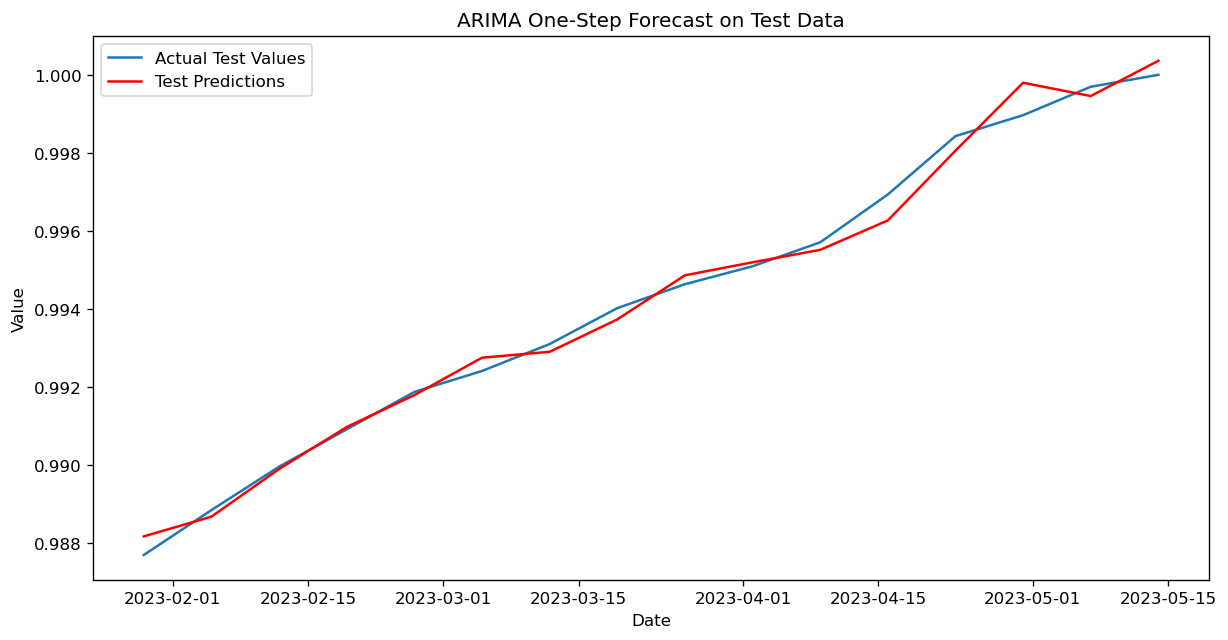

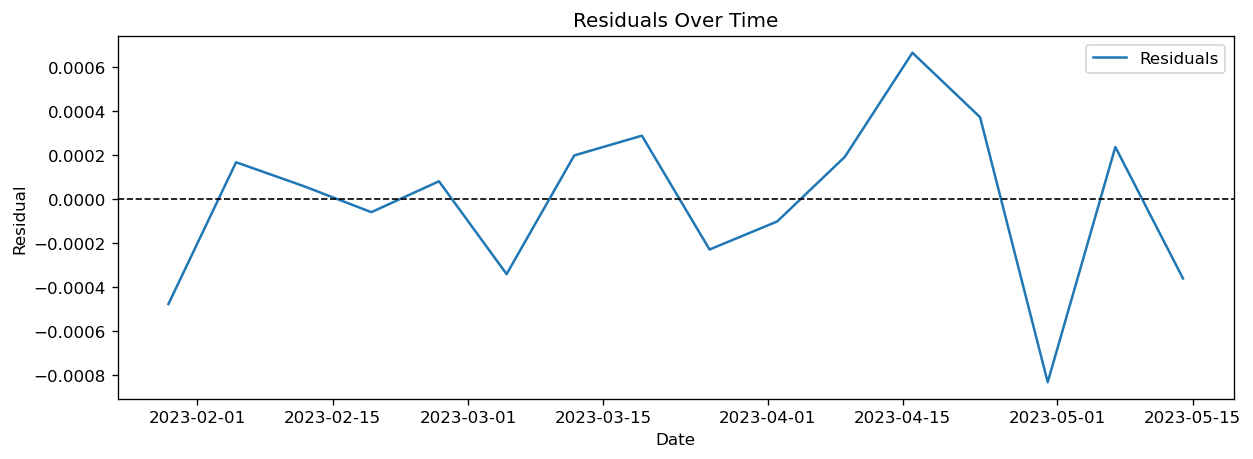

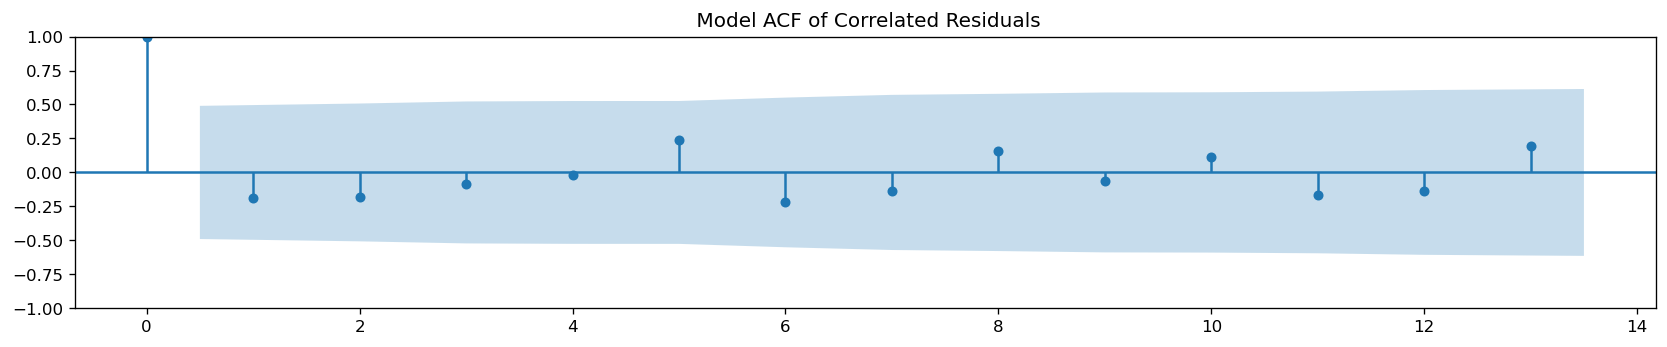

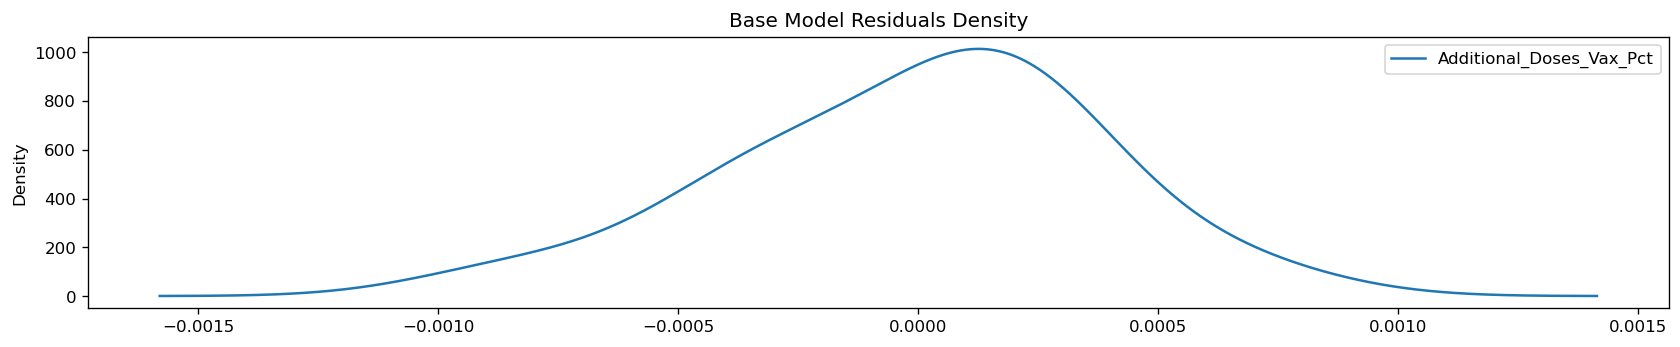

In [250]:
# Fit ARIMA model on the training data
model = ARIMA(train_data, order=(1, 1, 0))
model_fit = model.fit()
train_size = len(train_data.values)
# Initialize empty lists to store predictions and residuals
predictions = []
residuals = []

# Perform rolling one-step forecast on the test data
for i in range(len(test_data)):
    # Fit the model on the available training data
    model = ARIMA(data[:train_size + i], order=(1, 1, 0))
    model_fit = model.fit()
    
    # Make a one-step forecast
    yhat = model_fit.forecast(steps=1)[0]
    
    # Append the prediction to the list
    predictions.append(yhat)
    
    # Append the residual to the list
    residuals.append(test_data.iloc[i] - yhat)

# Calculate Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(test_data, predictions))
print(f"Test RMSE: {rmse}")

# Plot the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Test Values')
plt.plot(test_data.index, predictions, label='Test Predictions', color='red')
plt.title('ARIMA One-Step Forecast on Test Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot the residuals over time
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, residuals, label='Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

residuals = pd.DataFrame(residuals)
# Residuals ACF
plt.figsize=(10, 8)
acf_original = plot_acf(residuals)
plt.title(" Model ACF of Correlated Residuals")
plt.show()

# Residual Density
residuals.plot(kind='kde', title='Base Model Residuals Density')
plt.show()

- In the pursuit of optimizing my rolling one-step forecast ARIMA model, I employed a grid search to systematically explore various combinations of model parameters. This rigorous search involved testing different values for the autoregressive order (p), differencing order (d), and moving average order (q). The grid search not only fine-tuned the model but also provided insights into the most effective parameter configuration for accurate predictions. The result of the grid search revealed that the optimal set of parameters was p=1, d=1, q=0. This configuration demonstrated a remarkably low test root mean square error (RMSE), indicating the model's enhanced predictive performance. The advantages of using a grid search lie in its systematic and exhaustive approach, allowing for the identification of the most suitable parameters from a wide range of possibilities. By leveraging grid search, I could efficiently navigate the parameter space, ultimately enhancing the accuracy of my rolling one-step forecast ARIMA model.
- In my analysis employing a rolling one-step forecast ARIMA model, I observed a relatively uniform distribution of residuals. Although the mean for the residuals plot was not precisely zero, it closely approached this value. Furthermore, the predictions from the model exhibited a close fit to the actual values. This outcome aligns with expectations, considering the nature of a rolling one-step forecast. By continuously updating the model with the latest data, the approach allows for a more adaptive response to evolving patterns in the time series. This adaptability likely contributes to the model's ability to generate predictions that closely match the actual values, resulting in a more uniform distribution of residuals. The observed improvements in the rolling one-step forecast model make sense in contrast to the standard ARIMA model, which exhibited higher RMSE and poor residual characteristics. The rolling approach's ability to capture changing dynamics and incorporate recent information likely contributes to its superior performance in this scenario.